In [1]:
import matplotlib.pyplot as plt
import numpy as np

import findlay2025a as f25a
import wisc_ecephys_tools as wet
from ecephys import plot as eplt
from ecephys import sglxr, wne, xrsig

In [2]:
subject = "CNPIX14-Francis"
sglx_subject = wet.get_sglx_subject(subject)
experiment = f25a.constants.Experiments.COW
s3 = f25a.core.get_project("shared")
nb = f25a.core.get_project("seahorse")

In [3]:
opts = s3.load_experiment_subject_params(experiment, sglx_subject.name)
prb = opts["spwrProbe"]
bad_channels = opts["probes"][prb]["badChannels"]
lftab = sglx_subject.get_lfp_bin_table(experiment, probe=prb)

In [141]:
lfFile = lftab.iloc[14]
tStart = 6863.5692  # SPW w/ ripple
tStart = 6861.5772  # SPW w/ ripple
tStart = 6851.4180  # LMW w/ high-freq, but not ripple
tStart = 6845.9400  # SPW w/o ripple
tStart = 5803.4260  # SPW w/o ripple
tStart = 4446.3756  # 2x SPW w/o ripple

nChan: 385, nFileSamp: 18000001


(np.float64(4446.375220613701),
 np.float64(4447.375220618337),
 np.float64(-2372.3629285770444),
 np.float64(40617.01800610495))

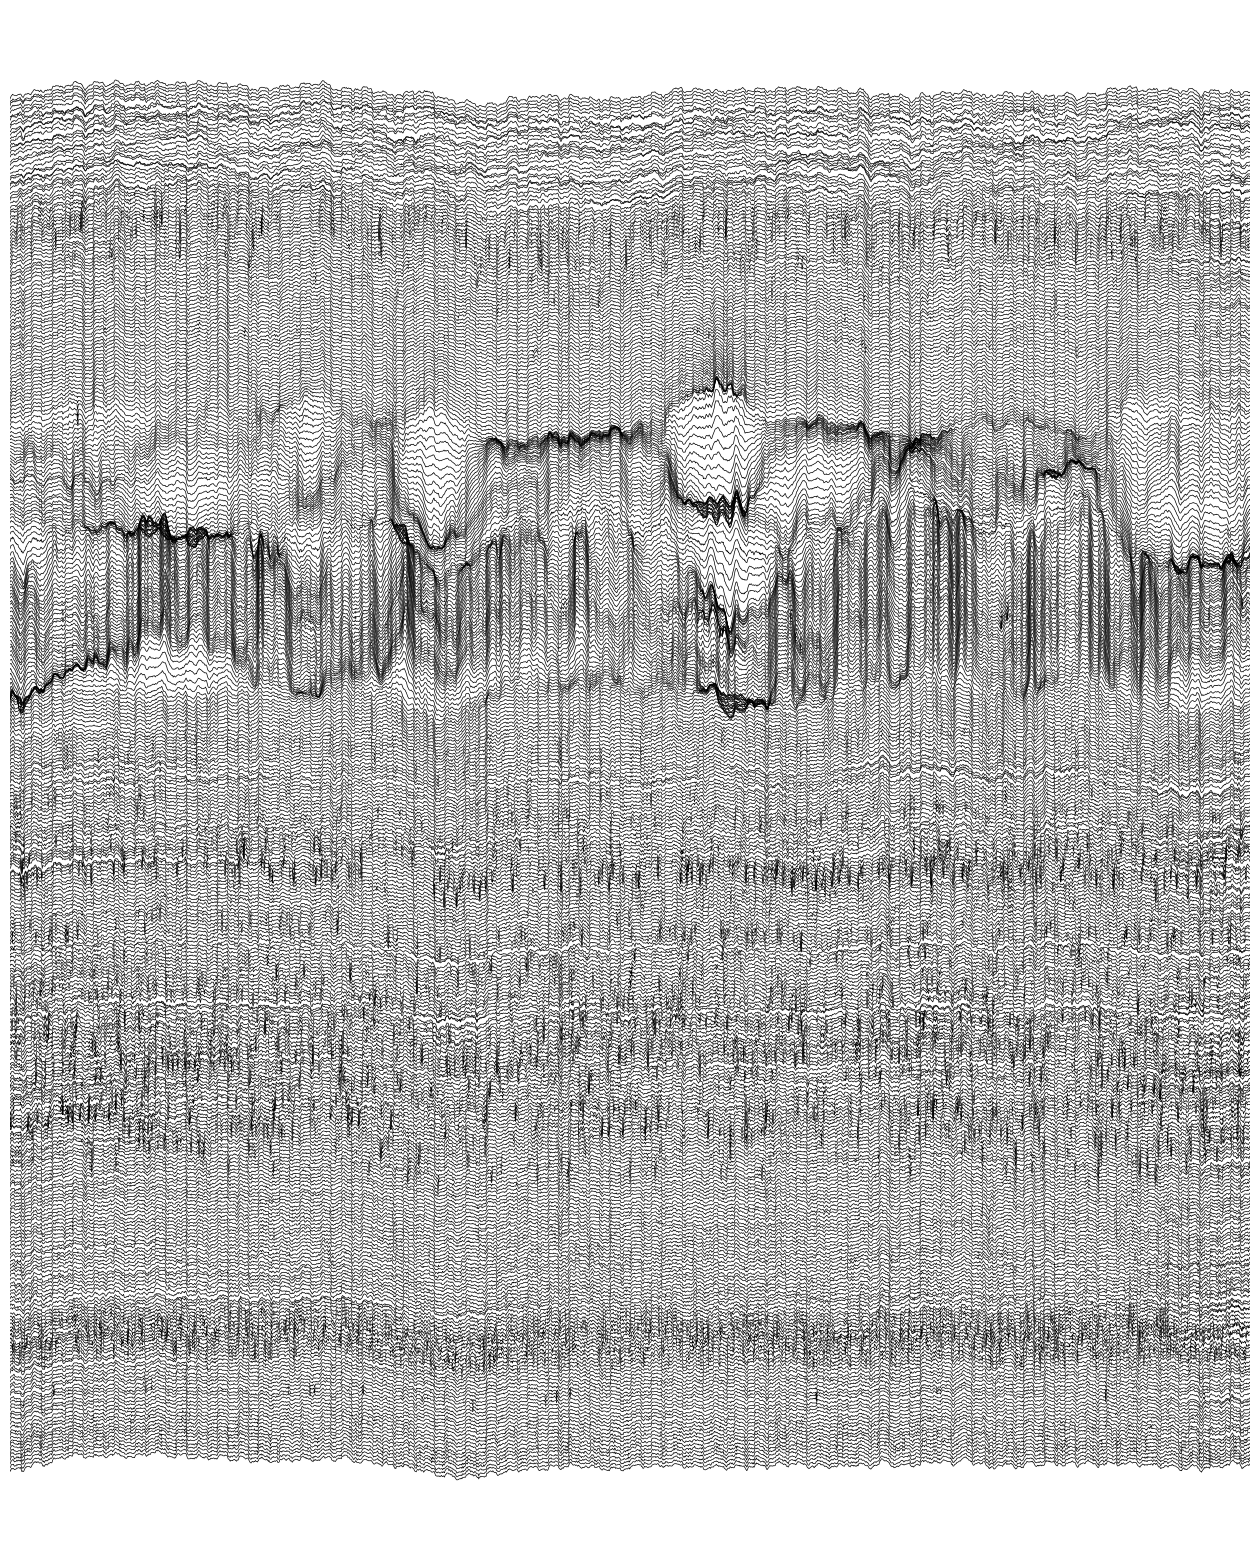

In [142]:
lf = sglxr.load_trigger(lfFile.path, start_time=tStart, end_time=tStart + 1.0)
lf = xrsig.spatially_interpolate_timeseries(lf, bad_channels)
lf = xrsig.butter_bandpass(lf, 1, 1200, order=3, plot=False)
fig, ax = plt.subplots(1, 1, figsize=(16, 20))
eplt.lfp_explorer(
    lf.time.values, lf.values, ax, vspace=100, zero_mean=False, flip_dv=True
)
ax.axis("off")

In [143]:
t2t = wne.sglx.utils.get_time_synchronizer(
    s3, sglx_subject, experiment, binfile=lfFile.path
)
tStart_synced = t2t(lfFile.expmtPrbAcqFirstTime + tStart)

In [163]:
lfp = f25a.core.open_hippocampal_lfps(sglx_subject.name, experiment)
lfp_ = lfp.sel(time=slice(tStart_synced, tStart_synced + 1)).load()

/home/gfindlay/projects/ece/ecephys/ecephys/wne/utils.py:87: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 128069. This could degrade performance. Instead, consider rechunking after loading.
  lf = xr.open_dataarray(lf_file, engine="zarr", chunks=chunks, **xr_kwargs)
/home/gfindlay/projects/ece/ecephys/ecephys/wne/utils.py:87: UserWarning: The specified chunks separate the stored chunks along dimension "channel" starting at index 262. This could degrade performance. Instead, consider rechunking after loading.
  lf = xr.open_dataarray(lf_file, engine="zarr", chunks=chunks, **xr_kwargs)


In [164]:
kcsd = (
    f25a.core.open_kcsd(sglx_subject.name, experiment)
    .assign_attrs(fs=lfp.fs)
    .assign_coords(acronym=lfp.acronym)
)
kcsd_ = kcsd.sel(time=slice(tStart_synced, tStart_synced + 1)).load()

In [165]:
spws = f25a.sharp_waves.read_spws(sglx_subject.name, experiment)
rips = f25a.ripples.read_ripples(sglx_subject.name, experiment)

In [166]:
in_plot = (spws["pk_time"] > tStart_synced) & (spws["pk_time"] < tStart_synced + 1)
spws_ = spws[in_plot]
spws_

start_time       end_time         pk_amp        pk_time  pk_chan_id  \
24595  105778.384489  105778.426089   90147.960938  105778.402089       175.0   
24596  105778.606889  105778.658089  122007.421875  105778.634089       175.0   

       duration  pk_chan_y state  zlog_amp  zlog_duration  ripple_count  \
24595    0.0416     5580.0  Wake -0.908096      -0.572785             0   
24596    0.0512     5580.0  Wake  0.398096      -0.040111             0   

       ripple_zlog_amp  ripple_zlog_duration  ripple_freq  ripple_zfreq  \
24595              NaN                   NaN   157.309780     -0.113272   
24596              NaN                   NaN   169.344503      0.937097   

       ripple_dB  ripple_zdB   log_amp  
24595   2.877332   -1.146146  4.954956  
24596   3.058337   -0.605292  5.086386

In [167]:
in_plot = (rips["pk_time"] > tStart_synced) & (rips["pk_time"] < tStart_synced + 1)
rips_ = rips[in_plot]
rips_

Empty DataFrame
Columns: [start_time, end_time, pk_amp, pk_time, pk_chan_id, duration, pk_chan_y, state, zlog_amp, zlog_duration, spw_count, spw_zlog_amp, spw_zlog_duration, dB, zdB, freq, zfreq, sink, zsink]
Index: []

[105778.  105778.2 105778.4 105778.6 105778.8 105779.  105779.2]


[Text(0, 4160.0, ''),
 Text(0, 4260.0, ''),
 Text(0, 4360.0, ''),
 Text(0, 4460.0, ''),
 Text(0, 4560.0, ''),
 Text(0, 4660.0, ''),
 Text(0, 4760.0, ''),
 Text(0, 4860.0, ''),
 Text(0, 4960.0, ''),
 Text(0, 5060.0, ''),
 Text(0, 5160.0, ''),
 Text(0, 5260.0, ''),
 Text(0, 5360.0, ''),
 Text(0, 5460.0, ''),
 Text(0, 5560.0, ''),
 Text(0, 5660.0, ''),
 Text(0, 5760.0, ''),
 Text(0, 5860.0, ''),
 Text(0, 5960.0, '')]

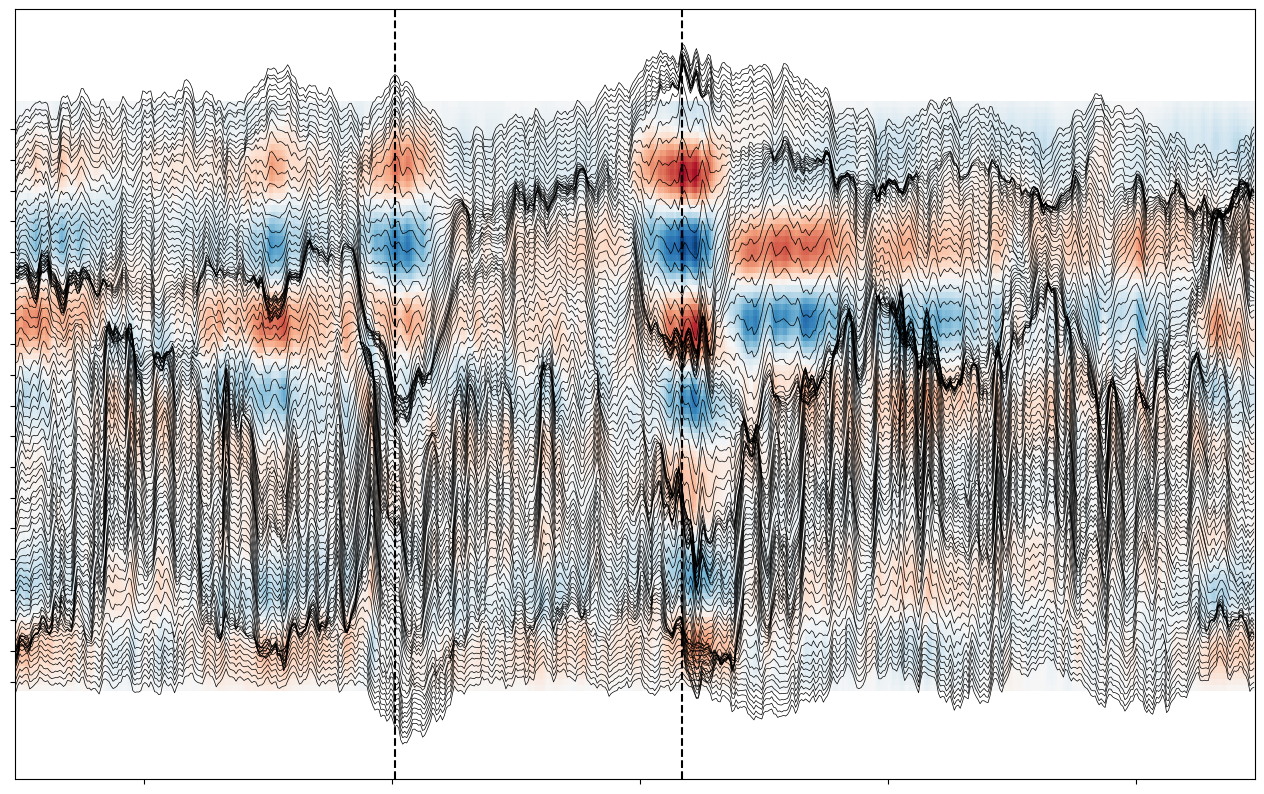

In [168]:
chan_slice = slice(2, -5)
ca1p_y = 5760.0

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
xrsig.plot_laminar_image_vertical(
    kcsd_.isel(channel=chan_slice), x="time", ax=ax, cmap="RdBu_r"
)
xrsig.plot_laminar_timeseries(lfp_.isel(channel=chan_slice), gain=0.25, ax=ax)
y = lfp_.isel(channel=chan_slice).y.values - ca1p_y
ax.set_yticklabels(y, fontsize=10)
ax.set_yticks(ax.get_yticks()[1::5])
ax.set_ylabel("Distance from CA1 stratum pyramidale (um)")
# ax.set_xlim(-0.1, 0.1)
# ax.set_xticks([-0.1, 0, 0.1])
# ax.set_xticklabels(["-100 ms", "0", "+100 ms"], fontsize=10)
ax.set_xlabel(None)
for spw in spws_.itertuples():
    ax.axvline(spw.pk_time, color="k", linestyle="--")
for rip in rips_.itertuples():
    ax.axvline(rip.pk_time, color="g", linestyle="--")
print(ax.get_xticks())

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])

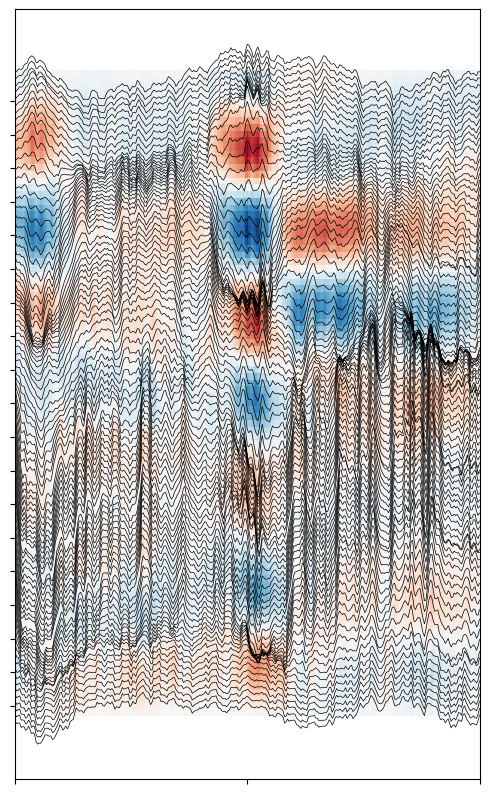

In [ ]:
# SPWs w/ ripple
# t_spw = spws.loc[24837]["pk_time"] # gain 0.07
# t_spw = spws.loc[24883]["pk_time"] # gain 0.07
# LMW w/ high-freq, but not ripple
# t_spw = None
# SPWs w/o ripple
# t_spw = 108178.34 # gain ~0.14
# t_spw = spws.loc[24754]["pk_time"] # gain 0.14
# t_spw = spws.loc[24595]["pk_time"] # gain 0.14
t_spw = spws.loc[24596]["pk_time"]  # gain 0.14
# t_spw = spws.loc[24596]["pk_time"] - 0.06 # gain 0.14

window = 0.250
lfp_ = lfp.sel(time=slice(t_spw - window, t_spw + window)).load()
lfp_ = xrsig.butter_bandpass(lfp_, 1, np.floor(lfp_.fs / 2), order=3, plot=False)
lfp_ = lfp_.assign_coords(time=lfp_.time.values - t_spw)
kcsd_ = kcsd.sel(time=slice(t_spw - window, t_spw + window)).load()
kcsd_ = kcsd_.assign_coords(time=kcsd_.time.values - t_spw)

chan_slice = slice(2, -5)
ca1p_y = 5760.0

fig, ax = plt.subplots(1, 1, figsize=(6, 10))
xrsig.plot_laminar_image_vertical(
    kcsd_.isel(channel=chan_slice), x="time", ax=ax, cmap="RdBu_r"
)
xrsig.plot_laminar_timeseries(lfp_.isel(channel=chan_slice), gain=0.14, ax=ax)
y = lfp_.isel(channel=chan_slice).y.values - ca1p_y
ax.set_yticklabels(y, fontsize=10)
ax.set_yticks(ax.get_yticks()[1::5])
ax.set_ylabel("Distance from CA1 stratum pyramidale (um)")
ax.set_xlim(-window, window)
ax.set_xticks([-window, 0, window])
ax.set_xticklabels(
    [f"-{int(window * 1000)} ms", "0", f"+{int(window * 1000)} ms"], fontsize=10
)
ax.set_xlabel(None)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])

fig.savefig(
    nb.get_project_file(f"figures/spw_no_ripple_example_{t_spw}.png"),
    dpi=600,
    bbox_inches="tight",
)

In [194]:
ca1p_lfps = lfp_.sel(channel=(lfp_.y == ca1p_y))
ca1p_cwt = xrsig.cwt(ca1p_lfps).squeeze()
ca1p_cwt = np.abs(ca1p_cwt) ** 2

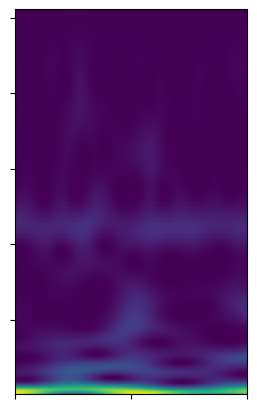

In [195]:
fig, ax = plt.subplots(figsize=(3, 5))
da_ = ca1p_cwt.sel(frequency=slice(50, 310))
ax.pcolormesh(
    da_.time.values,
    da_.frequency.values,
    da_.values,
    shading="gouraud",
)
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel(None)
ax.set_xlim(-0.1, 0.1)
ax.set_xticks([-0.1, 0, 0.1])
ax.set_xticklabels(["-100 ms", "0", "+100 ms"])

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])

fig.savefig(
    nb.get_project_file(f"figures/spw_no_ripple_example_cwt_{t_spw}.png"),
    dpi=600,
    bbox_inches="tight",
)